## Process LAI

In this notebook, previously prepared LAI data is further processed to retrieve monthly, yearly and spatially aggregated mean LAI values. The following steps are included:
- Use AVHRR and MODIS LAI data that has been quality filtered and cropped to NL / BL forest area
- Calculate monthly and yearly mean values for each pixel
- Spatially aggregate LAI for each federal state to retrieve mean value per state and year

In [1]:
# import libraries
import os
import glob
import xarray as xr
import pandas as pd
import geopandas as gpd
import rasterio
import odc.stac
import pathlib
import warnings

In [2]:
# set working directory
os.chdir("E:/Master/Thesis/3_Data")
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: E:\Master\Thesis\3_Data


In [3]:
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [4]:
# create list with forest types
forest_types = ("NL", "BL")

In [ ]:
# loop over years to calculate monthly and yearly mean lai values per pixel
# first, process lai from AVHRR data 

for year in range(1981, 2000):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./LAI/10Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        lai = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        lai_mon_mean = lai.resample(time="1MS", skipna=True).mean("time")
        
        # calculate yearly mean values
        lai_year_mean = lai.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        lai_mon_mean.LAI.encoding.update(comp)
        lai_year_mean.LAI.encoding.update(comp)

        # save created datasets as netCDF4 files
        lai_mon_mean.to_netcdf(f"./LAI/Monthly/LAI_mon_mean_{year}_{forest_type}.nc")
        lai_year_mean.to_netcdf(f"./LAI/Yearly/LAI_year_mean_{year}_{forest_type}.nc")

In [ ]:
# then, process LAI from MODIS data 

for year in range(2000, 2025):
    
    # process needleleaved and broadleaved forest
    for f in range(len(forest_types)):
        forest_type = forest_types[f]

        # get all files of according year that belong to forest type
        directory = f"./LAI/8Daily/{year}"
        filelist = glob.glob(os.path.join(directory, f"*{forest_type}*.nc"))

        # open netCDF dataset of corresponding year with all daily datasets concatenated
        lai = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

        # calculate monthly mean values
        lai_mon_mean = lai.resample(time="1MS", skipna=True).mean("time")

        # calculate yearly mean values
        lai_year_mean = lai.resample(time="1YS", skipna=True).mean("time")

        # compress data to reduce size
        comp = dict(zlib=True, complevel=4)
        lai_mon_mean.LAI.encoding.update(comp)
        lai_year_mean.LAI.encoding.update(comp)

        # save created datasets as netCDF4 files
        lai_mon_mean.to_netcdf(f"./LAI/Monthly/LAI_mon_mean_{year}_{forest_type}.nc")
        lai_year_mean.to_netcdf(f"./LAI/Yearly/LAI_year_mean_{year}_{forest_type}.nc")

In [7]:
# look at exemplary datasets to get an overview
lai_mon_mean

<xarray.Dataset> Size: 995MB
Dimensions:      (time: 12, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 96B 2024-01-01 2024-02-01 ... 2024-12-01
Data variables:
    LAI          (time, lat, lon) float64 995MB dask.array<chunksize=(1, 1476, 1755), meta=np.ndarray>

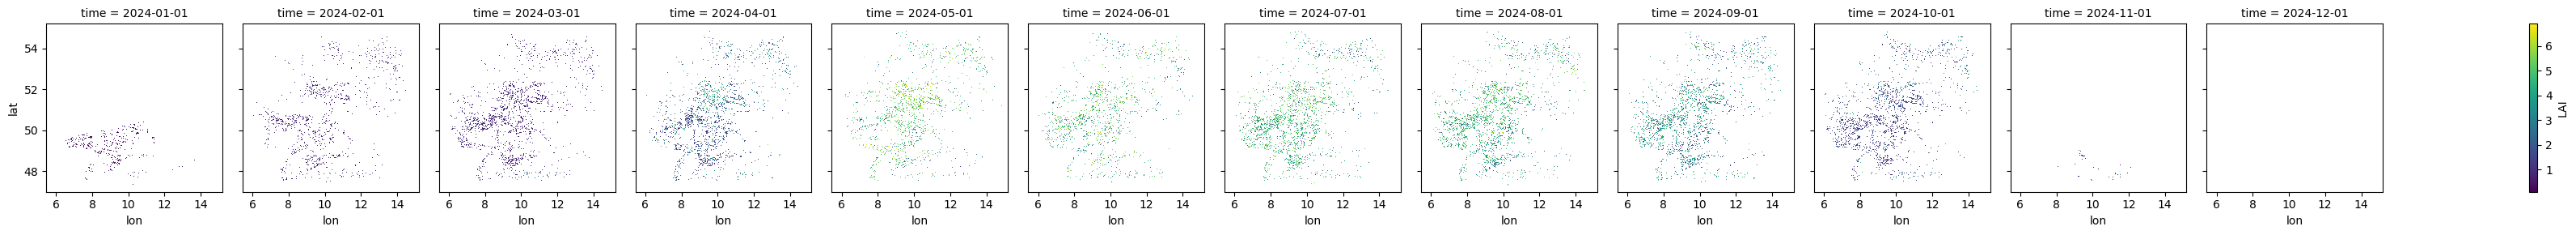

In [8]:
lai_mon_mean.LAI.sel(time = slice('2024-01', '2024-12')).plot(col="time")

In [9]:
lai_year_mean

<xarray.Dataset> Size: 83MB
Dimensions:      (time: 1, lat: 2952, lon: 3510)
Coordinates:
    crs          int8 1B -127
    spatial_ref  int64 8B 0
  * lon          (lon) float64 28kB 5.451 5.454 5.457 5.46 ... 15.19 15.2 15.2
  * lat          (lat) float64 24kB 55.2 55.2 55.19 55.19 ... 47.01 47.0 47.0
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables:
    LAI          (time, lat, lon) float64 83MB dask.array<chunksize=(1, 1476, 1755), meta=np.ndarray>

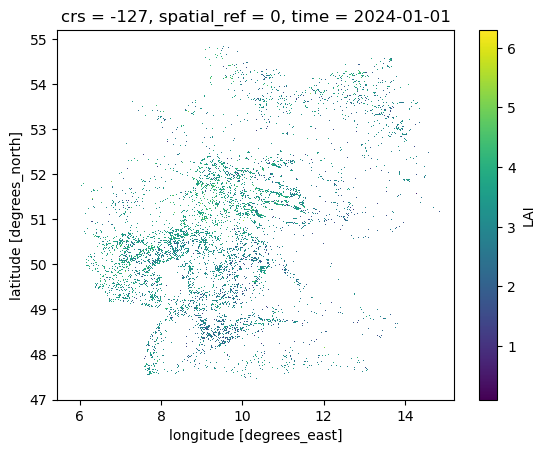

In [10]:
lai_year_mean.LAI.plot()

In [11]:
# spatially aggregate yearly lai data
# to get mean values for Germany and federal states

In [12]:
# first, get values for broadleaved forest
# load all yearly lai values as one dataset
directory = f"./LAI/Yearly"
filelist = glob.glob(os.path.join(directory, "*BL*.nc"))
lai_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [13]:
# calculate mean lai values per year for Germany
lai_yearly_spatial_means = lai_yearly.mean(['lon','lat'], skipna=True).to_dataframe()
lai_yearly_spatial_means

,LAI,spatial_ref,crs
time,,,
1981-01-01,1.603212,0,-127
1982-01-01,1.475147,0,-127
1983-01-01,1.585415,0,-127
1984-01-01,1.724143,0,-127
1985-01-01,2.195476,0,-127
1986-01-01,1.849949,0,-127
1987-01-01,1.697804,0,-127
1988-01-01,1.676723,0,-127
1989-01-01,1.877538,0,-127


In [14]:
# drop unneeded columns
lai_yearly_spatial_means = lai_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [15]:
# rename column with lai value to show area
lai_yearly_spatial_means.rename({"LAI":"GER"}, axis=1, inplace=True)

In [16]:
# now, calculate yearly mean lai values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    lai_ex = lai_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=lai_ex.odc.geobox.shape,
                                                transform=lai_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly lai data
    lai_state = lai_yearly["LAI"].where(~state_mask)

    # calculate yearly mean lai of state and extract to dataframe
    lai_state_spatial_means = lai_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    lai_state_spatial_means = lai_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean lai values of state to dataframe
    lai_yearly_spatial_means[state] = lai_state_spatial_means["LAI"]   

In [17]:
lai_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,1.603212,1.380945,0.923929,1.627723,1.663396,1.764287,1.660295,1.482340,1.382545,1.538616,1.865913,1.622617,1.593011,1.483826,1.307613,1.401972,1.482091
1982-01-01,1.475147,1.254072,0.843029,1.600270,1.480526,1.430005,1.515168,1.352041,1.487681,1.397170,1.480917,1.552220,1.821153,1.397584,1.010075,1.087113,1.228897
1983-01-01,1.585415,1.434457,0.960435,1.599040,1.620767,1.461160,1.699737,1.419849,1.468986,1.534012,1.616609,1.644208,1.729419,1.501528,1.216199,1.332182,1.417547
1984-01-01,1.724143,1.379212,1.071144,1.866934,1.729382,1.512689,1.729863,1.477115,1.533410,1.752693,1.763469,1.731430,1.931169,1.576323,1.383865,1.513417,1.707596
1985-01-01,2.195476,1.585518,1.011420,2.281827,2.369388,1.859973,2.357896,1.790190,1.802504,2.055975,2.104343,2.342590,2.163077,2.019526,1.603890,1.854222,2.191834
1986-01-01,1.849949,1.389741,0.930582,2.006071,1.863695,1.491768,1.960639,1.487744,1.476542,1.833305,1.869050,1.980036,1.798140,1.830974,1.200377,1.543772,1.700978
1987-01-01,1.697804,1.460714,1.008523,1.730643,1.810734,1.686379,1.826526,1.355651,1.552201,1.592051,1.573382,1.747849,1.650192,1.738711,1.386750,1.477682,1.679102
1988-01-01,1.676723,1.280319,1.005116,1.710446,1.798192,1.548896,1.806180,1.473962,1.412074,1.680885,1.587794,1.694496,1.752710,1.853860,1.291985,1.367329,1.660846
1989-01-01,1.877538,1.302363,0.841919,1.933181,1.963268,1.461960,2.018462,1.501307,1.580391,1.766512,1.885935,2.123110,2.212298,1.863556,1.220321,1.393790,1.550046


In [18]:
# save as csv dataset
lai_yearly_spatial_means.to_csv("./Tables/Spatial_Means/LAI_Yearly_Spatial_Means_BL.csv")

In [19]:
# now take the same steps for needleleaved forest
# load all yearly lai values as one dataset
directory = f"./LAI/Yearly"
filelist = glob.glob(os.path.join(directory, "*NL*.nc"))
lai_yearly = xr.open_mfdataset(filelist, concat_dim="time", combine="nested", engine="netcdf4")

In [20]:
# calculate mean lai values per year for Germany
lai_yearly_spatial_means = lai_yearly.mean(['lon','lat'], skipna=True).to_dataframe()

In [21]:
# drop unneeded columns
lai_yearly_spatial_means = lai_yearly_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

In [22]:
# rename column with lai value to show area
lai_yearly_spatial_means.rename({"LAI":"GER"}, axis=1, inplace=True)

In [23]:
# now, calculate yearly mean lai values for all federal states
# get list of shapefiles of all states
directory = "./Administrative_Borders"
files = list(pathlib.Path(directory).glob('*.shp'))

# loop over filelist to process each state
for f in range(len(files)):
    file = files[f]

    # load state shapefile 
    state = str(file)[23:25]
    state_shp = gpd.read_file(file)

    # reproject shapefile to match netcdf data
    state_shp = state_shp.to_crs(4326)

    # extract one date to create mask of state with dimensions of data
    lai_ex = lai_yearly.sel(time = "1999-01-01", method = "nearest")

    # create mask of research area using the dimensions of the exemplary data
    state_mask = rasterio.features.geometry_mask(state_shp.geometry, 
                                                out_shape=lai_ex.odc.geobox.shape,
                                                transform=lai_ex.odc.geobox.affine,
                                                all_touched=False,
                                                invert=False)
    
    state_mask = xr.DataArray(state_mask, dims=("lat", "lon"))

    # mask yearly lai data
    lai_state = lai_yearly["LAI"].where(~state_mask)

    # calculate yearly mean lai of state and extract to dataframe
    lai_state_spatial_means = lai_state.mean(['lon','lat'], skipna=True).to_dataframe()

    # drop unneeded columns
    lai_state_spatial_means = lai_state_spatial_means.drop(['crs', 'spatial_ref'], axis=1)

    # add yearly mean lai values of state to dataframe
    lai_yearly_spatial_means[state] = lai_state_spatial_means["LAI"]   

In [24]:
lai_yearly_spatial_means

,GER,BB,BE,BW,BY,HB,HE,HH,MV,NI,NW,RP,SH,SL,SN,ST,TH
time,,,,,,,,,,,,,,,,,
1981-01-01,1.689057,1.328362,0.973017,2.014346,1.729760,1.641609,1.900211,1.378669,1.329298,1.673499,2.430114,1.868792,1.541037,1.477467,1.615228,1.441650,1.728122
1982-01-01,1.392333,1.164061,0.890485,1.888668,1.405824,1.312568,1.496794,1.119081,1.427185,1.378941,1.659381,1.624670,1.722655,1.449590,1.189776,1.116031,1.248419
1983-01-01,1.572128,1.361288,1.047754,1.963267,1.643549,1.616355,1.689360,1.235322,1.492145,1.567687,1.825298,1.774927,1.739660,1.618153,1.334002,1.366954,1.392775
1984-01-01,1.631559,1.314758,1.095959,2.086119,1.685747,1.565830,1.735208,1.323279,1.434173,1.727055,1.891452,1.858524,1.839718,1.672704,1.386660,1.436797,1.615923
1985-01-01,1.918750,1.403981,1.044604,2.321557,2.089710,1.542745,2.311212,1.377199,1.702128,1.891709,2.343803,2.398552,2.191292,2.128564,1.673089,1.608732,1.964365
1986-01-01,1.616105,1.209311,0.965143,2.234032,1.645638,1.291991,1.962288,1.221871,1.413060,1.653894,2.133301,2.002005,1.686936,1.849205,1.278274,1.335980,1.533814
1987-01-01,1.539816,1.282055,1.020727,1.779030,1.647255,1.496833,1.806163,1.133354,1.465254,1.516038,1.654320,1.746640,1.616958,1.643907,1.337552,1.305273,1.653128
1988-01-01,1.466539,1.199881,1.098531,1.672225,1.493419,1.565021,1.779578,1.388476,1.308464,1.566019,1.727091,1.713100,1.820729,1.922183,1.335167,1.219353,1.504883
1989-01-01,1.643247,1.154098,0.878086,2.271571,1.781755,1.829323,1.972976,1.266311,1.419789,1.648082,2.116485,2.239522,2.091127,1.921067,1.275499,1.250045,1.471451


In [25]:
# save as csv dataset
lai_yearly_spatial_means.to_csv("./Tables/Spatial_Means/LAI_Yearly_Spatial_Means_NL.csv")